# 07 - Bias correction of CMIP6 climate data

## Performing bias correction on climate model data to perform climate change impact studies on hydrology

This notebook will guide you on how to conduct bias correction of climate model outputs that will be fed as inputs to the hydrological model `Raven` to perform climate change impact studies on hydrology. 

## Geographic data
In this tutorial, we will be using the shapefile or GeoJSON file for watershed contours as generated in the tutorial notebooks #03 (03_Extract_geographical_watershed_properties.ipynb) and #04 (04_Delineating_watersheds.ipynb). The file can be uploaded to your workspace here and used directly in the cells below. In the first section, we present a quick demonstration of the bias-correction approach on a very small and predetermined dataset, and in the second section we generalize it so you can apply the bias-correction to your own data. 

In [1]:
import xarray as xr
import datetime as dt
import xclim.sdba as sdba
import xclim
import gcsfs
import fsspec
import s3fs
import intake

from clisops.core import subset

## Application to a real catchment and test-case.
In this notebook, we will perform bias-correction on a real catchment using real data! You can change the input file for the contours, the catchment properties and other such parameters. The previous notebooks show how to extract basin area, latitude, and longitude, so use those to generate the required information if it is not readily available for your catchment.

Let's first start by providing information regarding the catchment:



In [2]:
basin_contour = 'input.geojson' # Can be generated using notebook "04_Delineating watersheds"

reference_start_day = dt.datetime(1980, 12, 31)
reference_stop_day = dt.datetime(1991, 1, 1) # Notice we are using one day before and one day after the desired period of 1981-01-01 to 1990-12-31. This is to account for any UTC shifts that might require getting data in a previous or later time.
future_start_day = dt.datetime(2080, 12, 31)
future_stop_day = dt.datetime(2091, 1, 1) # Notice we are using one day before and one day after the desired period of 1981-01-01 to 1990-12-31. This is to account for any UTC shifts that might require getting data in a previous or later time.

'''
Choose a climate model from the list below, which have the daily data required for Raven. 

ACCESS-CM2
ACCESS-ESM1-5
AWI-CM-1-1-MR
BCC-CSM2-MR
CESM2-WACCM
CMCC-CM2-SR5
CMCC-ESM2
CanESM5
EC-Earth3
EC-Earth3-CC
EC-Earth3-Veg
EC-Earth3-Veg-LR
FGOALS-g3
GFDL-CM4
GFDL-ESM4
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
KIOST-ESM
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
NorESM2-LM
NorESM2-MM
'''

climate_model = 'MIROC6'



Here we use the `xclim` utilities to bias-correct CMIP6 GCM data using ERA5 reanalysis data as the reference. See `xclim` documentation for more options! (https://xclim.readthedocs.io/en/stable/notebooks/sdba.html)

The first step will be to load the files and load the model to use for the bias correction - the `detrended quantile mapping`.

In [3]:
#Prepare the filesystem that allows reading data. Data is read on the Google Cloud Services, which host a copy of the CMIP6 (and other) data. 
fsCMIP = gcsfs.GCSFileSystem(token='anon', access='read_only')

#Get the catalog info from the pangeo dataset, which basically is a list of links to the various products.
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

# We will add a wrapper to ensure that the following operations will preserve the original data attributes, such as units and variable names.
with xr.set_options(keep_attrs=True):

    # Load the files from the PanGEO catalogs, for reference and future variables of temperature and precipitation.
    query = dict(experiment_id=['historical'],table_id='day',variable_id=['tasmin'],member_id='r1i1p1f1',source_id=climate_model)
    col_subset = col.search(require_all_on=['source_id'], **query)
    mapper = fsCMIP.get_mapper(col_subset.df.zstore[0])
    historical_tasmin=subset.subset_shape(xr.open_zarr(mapper, consolidated=True).sel(time=slice(reference_start_day,reference_stop_day)), 'input.geojson').mean({'lat','lon'}).reset_coords('height',drop=True)['tasmin'].chunk(-1)

    query = dict(experiment_id=['historical'],table_id='day',variable_id=['tasmax'],member_id='r1i1p1f1',source_id=climate_model)
    col_subset = col.search(require_all_on=['source_id'], **query)
    mapper = fsCMIP.get_mapper(col_subset.df.zstore[0])
    historical_tasmax=subset.subset_shape(xr.open_zarr(mapper, consolidated=True).sel(time=slice(reference_start_day,reference_stop_day)), 'input.geojson').mean({'lat','lon'}).reset_coords('height',drop=True)['tasmax'].chunk(-1)

    query = dict(experiment_id=['historical'],table_id='day',variable_id=['pr'],member_id='r1i1p1f1',source_id=climate_model)
    col_subset = col.search(require_all_on=['source_id'], **query)
    mapper = fsCMIP.get_mapper(col_subset.df.zstore[0])
    historical_pr=subset.subset_shape(xr.open_zarr(mapper, consolidated=True).sel(time=slice(reference_start_day,reference_stop_day)), 'input.geojson').mean({'lat','lon'})['pr'].chunk(-1)

    query = dict(experiment_id=['ssp585'],table_id='day',variable_id=['tasmin'],member_id='r1i1p1f1',source_id=climate_model)
    col_subset = col.search(require_all_on=['source_id'], **query)
    mapper = fsCMIP.get_mapper(col_subset.df.zstore[0])
    future_tasmin=subset.subset_shape(xr.open_zarr(mapper, consolidated=True).sel(time=slice(future_start_day,future_stop_day)), 'input.geojson').mean({'lat','lon'}).reset_coords('height',drop=True)['tasmin'].chunk(-1)

    query = dict(experiment_id=['ssp585'],table_id='day',variable_id=['tasmax'],member_id='r1i1p1f1',source_id=climate_model)
    col_subset = col.search(require_all_on=['source_id'], **query)
    mapper = fsCMIP.get_mapper(col_subset.df.zstore[0])
    future_tasmax=subset.subset_shape(xr.open_zarr(mapper, consolidated=True).sel(time=slice(future_start_day,future_stop_day)), 'input.geojson').mean({'lat','lon'}).reset_coords('height',drop=True)['tasmax'].chunk(-1)

    query = dict(experiment_id=['ssp585'],table_id='day',variable_id=['pr'],member_id='r1i1p1f1',source_id=climate_model)
    col_subset = col.search(require_all_on=['source_id'], **query)
    mapper = fsCMIP.get_mapper(col_subset.df.zstore[0])
    future_pr=subset.subset_shape(xr.open_zarr(mapper, consolidated=True).sel(time=slice(future_start_day,future_stop_day)), 'input.geojson').mean({'lat','lon'})['pr'].chunk(-1)



/tmp/ipykernel_6091/1238945690.py:14: UserWarning: CRS definitions are similar but raster lon values must be wrapped.
  historical_tasmin=subset.subset_shape(xr.open_zarr(mapper, consolidated=True).sel(time=slice(reference_start_day,reference_stop_day)), 'input.geojson').mean({'lat','lon'}).reset_coords('height',drop=True)['tasmin'].chunk(-1)
/opt/conda/envs/birdy/lib/python3.8/site-packages/clisops/core/subset.py:528: UserWarning: Wrapping longitudes at 180 degrees.
  warnings.warn("Wrapping longitudes at 180 degrees.")
/tmp/ipykernel_6091/1238945690.py:19: UserWarning: CRS definitions are similar but raster lon values must be wrapped.
  historical_tasmax=subset.subset_shape(xr.open_zarr(mapper, consolidated=True).sel(time=slice(reference_start_day,reference_stop_day)), 'input.geojson').mean({'lat','lon'}).reset_coords('height',drop=True)['tasmax'].chunk(-1)
/opt/conda/envs/birdy/lib/python3.8/site-packages/clisops/core/subset.py:528: UserWarning: Wrapping longitudes at 180 degrees.
 

### We have extracted the historical period and future period data from the GCM. Now we need the reference data to use as the baseline for bias-correction. Here we will use ERA5 data.


In [4]:
# If you already have the data generated from the "05_Extracting_external_data" notebook, then use the data directly. If not, then regenerate it.


'''
# If we wanted to use the data we already generated, only use this code snippet and comment-out the rest of this block. By default, this code will regenerate the data.
ERA5_tmin=xr.open_dataset('ERA5_tmin.nc')
ERA5_tmax=xr.open_dataset('ERA5_tmax.nc')
ERA5_pr = xr.open_dataset('ERA5_precip.nc')
'''



# Get the ERA5 data from the Wasabi/Amazon S3 server. Will eventually be replaced by the more efficient direct call with auto-updating timesteps.
# Future code:
'''
catalog_name = 'https://raw.githubusercontent.com/hydrocloudservices/catalogs/main/catalogs/atmosphere.yaml'
cat=intake.open_catalog(catalog_name)
ds=cat.era5_hourly_reanalysis_single_levels_ts.to_dask()
'''

# For now, let's use this method:
''' 
Configuration keys. Boilerplate, should not be changed.
'''
CLIENT_KWARGS = {'endpoint_url': 'https://s3.wasabisys.com','region_name': 'us-east-1'}
CONFIG_KWARGS = {'max_pool_connections': 100}
STORAGE_OPTIONS = {'anon': True,'client_kwargs': CLIENT_KWARGS,'config_kwargs': CONFIG_KWARGS}

'''
Prepare the filesystem and mapper that points to the data itself on the AmazonS3 directory
'''
fsERA5 = fsspec.filesystem('s3', **STORAGE_OPTIONS)
mapper = fsERA5.get_mapper('s3://era5/world/reanalysis/single-levels/zarr-temporal/2021-06-30')

'''
Get the ERA5 data
'''
# We will add a wrapper to ensure that the following operations will preserve the original data attributes, such as units and variable names.
with xr.set_options(keep_attrs=True):
    ds = xr.open_zarr(mapper, consolidated=True).sel(time=slice(reference_start_day,reference_stop_day))
    sub=subset.subset_shape(ds,'input.geojson').mean({'latitude','longitude'})
    ERA5_tmin=sub['t2m'].resample(time='1D').min().chunk(-1,-1,-1)
    ERA5_tmax=sub['t2m'].resample(time='1D').max().chunk(-1,-1,-1)
    ERA5_pr = sub['tp'].resample(time='1D').mean().chunk(-1,-1,-1)

In [5]:
# Here we need to make sure that our units are all in the correct format.
# Let's start with precipitation:
ERA5_pr = xclim.core.units.convert_units_to(ERA5_pr,'mm',context='hydro')
# The CMIP data is a rate rather than an absolute value, so let's get the absolute values:
historical_pr = xclim.core.units.rate2amount(historical_pr)
future_pr = xclim.core.units.rate2amount(future_pr)

# Now we can actually convert units in absolute terms.
historical_pr = xclim.core.units.convert_units_to(historical_pr,'mm',context='hydro')
future_pr = xclim.core.units.convert_units_to(future_pr,'mm',context='hydro')

# Now let's do temperature:
ERA5_tmin = xclim.core.units.convert_units_to(ERA5_tmin,'degC')
ERA5_tmax = xclim.core.units.convert_units_to(ERA5_tmax,'degC')
historical_tasmin = xclim.core.units.convert_units_to(historical_tasmin,'degC')
historical_tasmax = xclim.core.units.convert_units_to(historical_tasmax,'degC')
future_tasmin = xclim.core.units.convert_units_to(future_tasmin,'degC')
future_tasmax = xclim.core.units.convert_units_to(future_tasmax,'degC')

The model is now going to be trained to find correction factors between the reference dataset (observations) and historical dataset (climate model outputs for the same time period). The correction factors obtained are then applied to both reference and future climate outputs to correct them. This step is called the bias correction.

In [6]:
# Use xclim utilities (sbda) to give information on the type of window used for the bias correction.
group_month_window = sdba.utils.Grouper("time.dayofyear", window=15)

In [7]:
# This is an adjusting function. It builds the tool that will perform the corrections.
Adjustment = sdba.DetrendedQuantileMapping.train(ref=ERA5_pr, hist=historical_pr,
    nquantiles=50, 
    kind="+", 
    group=group_month_window
)

# Apply the correction factors on the reference period
corrected_ref_precip = Adjustment.adjust(historical_pr, interp="linear")

# Apply the correction factors on the future period
corrected_fut_precip = Adjustment.adjust(future_pr, interp="linear")

# Ensure that the precipitation is non-negative, which can happen with some climate models
corrected_ref_precip[corrected_ref_precip < 0] = 0
corrected_fut_precip[corrected_fut_precip < 0] = 0
print(corrected_ref_precip)

# Train the model to find the correction factors for the maximum temperature (tasmax) data
Adjustment = sdba.DetrendedQuantileMapping.train(ref=ERA5_tmax, hist=historical_tasmax,
    nquantiles=50, 
    kind="+", 
    group=group_month_window
)

# Apply the correction factors on the reference period
corrected_ref_tasmax = Adjustment.adjust(historical_tasmax, interp="linear")

# Apply the correction factors on the future period
corrected_fut_tasmax = Adjustment.adjust(future_tasmax, interp="linear")

# Train the model to find the correction factors for the minimum temperature (tasmin) data
Adjustment = sdba.DetrendedQuantileMapping.train(ref=ERA5_tmin, hist=historical_tasmin,
    nquantiles=50, 
    kind="+", 
    group=group_month_window
)

# Apply the correction factors on the reference period
corrected_ref_tasmin = Adjustment.adjust(historical_tasmin, interp="linear")

# Apply the correction factors on the future period
corrected_fut_tasmin = Adjustment.adjust(future_tasmin, interp="linear")

/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:98: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:98: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:98: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(


<xarray.DataArray 'scen' (time: 3653)>
dask.array<setitem, shape=(3653,), dtype=float64, chunksize=(3653,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-12-31T12:00:00 ... 1990-12-31T12:00:00
Attributes:
    units:            mm
    history:          [2022-02-16 03:52:45] : Bias-adjusted with DetrendedQua...
    bias_adjustment:  DetrendedQuantileMapping(group=Grouper(add_dims=[], nam...


/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:98: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:98: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:98: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:98: UserWarning: Strange results could be returned when using dayofyear grouping on data defined in the proleptic_gregorian calendar 
  warn(
/opt/conda/envs/birdy/lib/python3.8/site-packages/xclim/sdba/adjustment.py:98: UserWarning: Strange results could be returned when u

The corrected reference and future data are then converted to netCDF files.

In [9]:
# Convert the reference corrected data into netCDF file
ref_dataset = xr.merge([
    corrected_ref_precip.to_dataset(name="pr"),
    corrected_ref_tasmax.to_dataset(name="tasmax"), 
    corrected_ref_tasmin.to_dataset(name="tasmin")
])
ref_dataset.to_netcdf("reference_dataset.nc")

# Convert the future corrected data into netCDF file
fut_dataset = xr.merge([
    corrected_fut_precip.to_dataset(name="pr"),
    corrected_fut_tasmax.to_dataset(name="tasmax"), 
    corrected_fut_tasmin.to_dataset(name="tasmin")
])
fut_dataset.to_netcdf("future_dataset.nc")

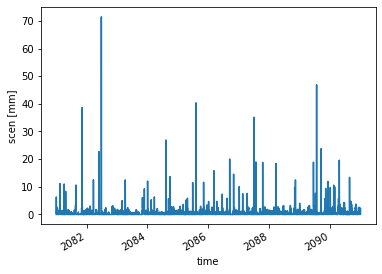

In [10]:
#Show the corrected future precipitation.
corrected_fut_precip.plot()

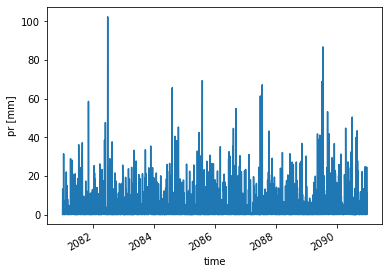

In [11]:
# Compare it to the future precipitation without bias-correction.
future_pr.plot()